# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.PytorchUtils import PytorchUtils
from utils.Visualisation import Visualisation

from dataset_creation.ImageCreation import ImageCreation

PyTorch version: 2.1.0+cu121


In [2]:
device = PytorchUtils.device_section()

In [3]:
WIDTH, HEIGHT = 64, 64
STROKE_SIZE = 2
IMAGE_FACTOR = 1.1
EPOCHS: int = 50
BATCH_SIZE: int = 16
MODEL = "linear"

In [4]:
CONV_MODEL_DATA = "conv" in MODEL

In [5]:
resources_folder = 'resources/sketchrnn'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)
class_size = {}

data = []

for class_name in classes:
    data_class = np.load(os.path.join(resources_folder, 'sketchrnn_' + class_name + '.npz'), allow_pickle=True, encoding="latin1")

    class_size[class_name] = len(data_class)
    data.append(data_class)

print(f'loaded numpy bitmaps, {nb_classes} classes')
print(len(data))
print(data[0].keys())
print(len(data[0]['train']))
print(len(data[0]['valid']))
print(len(data[0]['test']))

loaded numpy bitmaps, 8 classes
8
KeysView(NpzFile 'resources/sketchrnn/sketchrnn_apple.npz' with keys: test, train, valid)
70000
2500
2500


## Dataset creation

In [6]:
from dataset_creation.DataManagerNpz import DataManagerNpz

data_manager = DataManagerNpz()

training_data, training_labels, validation_data, validation_labels, test_data, test_labels = data_manager.parse_data(data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')
print(f'test dataset size : {len(test_data)}') 

training dataset size : 560000
validation dataset size : 20000
test dataset size : 20000


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

shuffled_test_data, shuffled_test_labels = data_manager.shuffle_dataset(test_data, test_labels)

In [8]:
from dataset_creation.StrokeImageDataset import StrokeImageDataset

len_subset = 20000
valid_test_subset = 5000

training_set = StrokeImageDataset(
        data=shuffled_training_data[:len_subset], 
        labels=shuffled_training_labels[:len_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

validation_set = StrokeImageDataset(
        data=shuffled_validation_data[:valid_test_subset], 
        labels=shuffled_validation_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

test_set = StrokeImageDataset(
        data=shuffled_test_data[:valid_test_subset], 
        labels=shuffled_test_labels[:valid_test_subset],
        width=WIDTH, height=HEIGHT, 
        stroke_size=STROKE_SIZE, factor=IMAGE_FACTOR, 
        reshape=CONV_MODEL_DATA, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)
test_loaded_set = DataLoader(test_set, batch_size=BATCH_SIZE , shuffle=True)

NameError: name 'CONV_MODEL_DATA' is not defined

In [ ]:
print(f'training set distribution :\n{Visualisation.dataset_distribution(classes, training_set)}')
print(f'validation set distribution :\n{Visualisation.dataset_distribution(classes, validation_set)}')
print(f'test set distribution :\n{Visualisation.dataset_distribution(classes, test_set)}')

training set distribution :
{0: 245, 1: 251, 2: 244, 3: 248, 4: 249, 5: 235, 6: 259, 7: 269}
validation set distribution :
{0: 67, 1: 58, 2: 72, 3: 59, 4: 63, 5: 55, 6: 66, 7: 60}
test set distribution :
{0: 58, 1: 44, 2: 65, 3: 76, 4: 53, 5: 56, 6: 80, 7: 68}


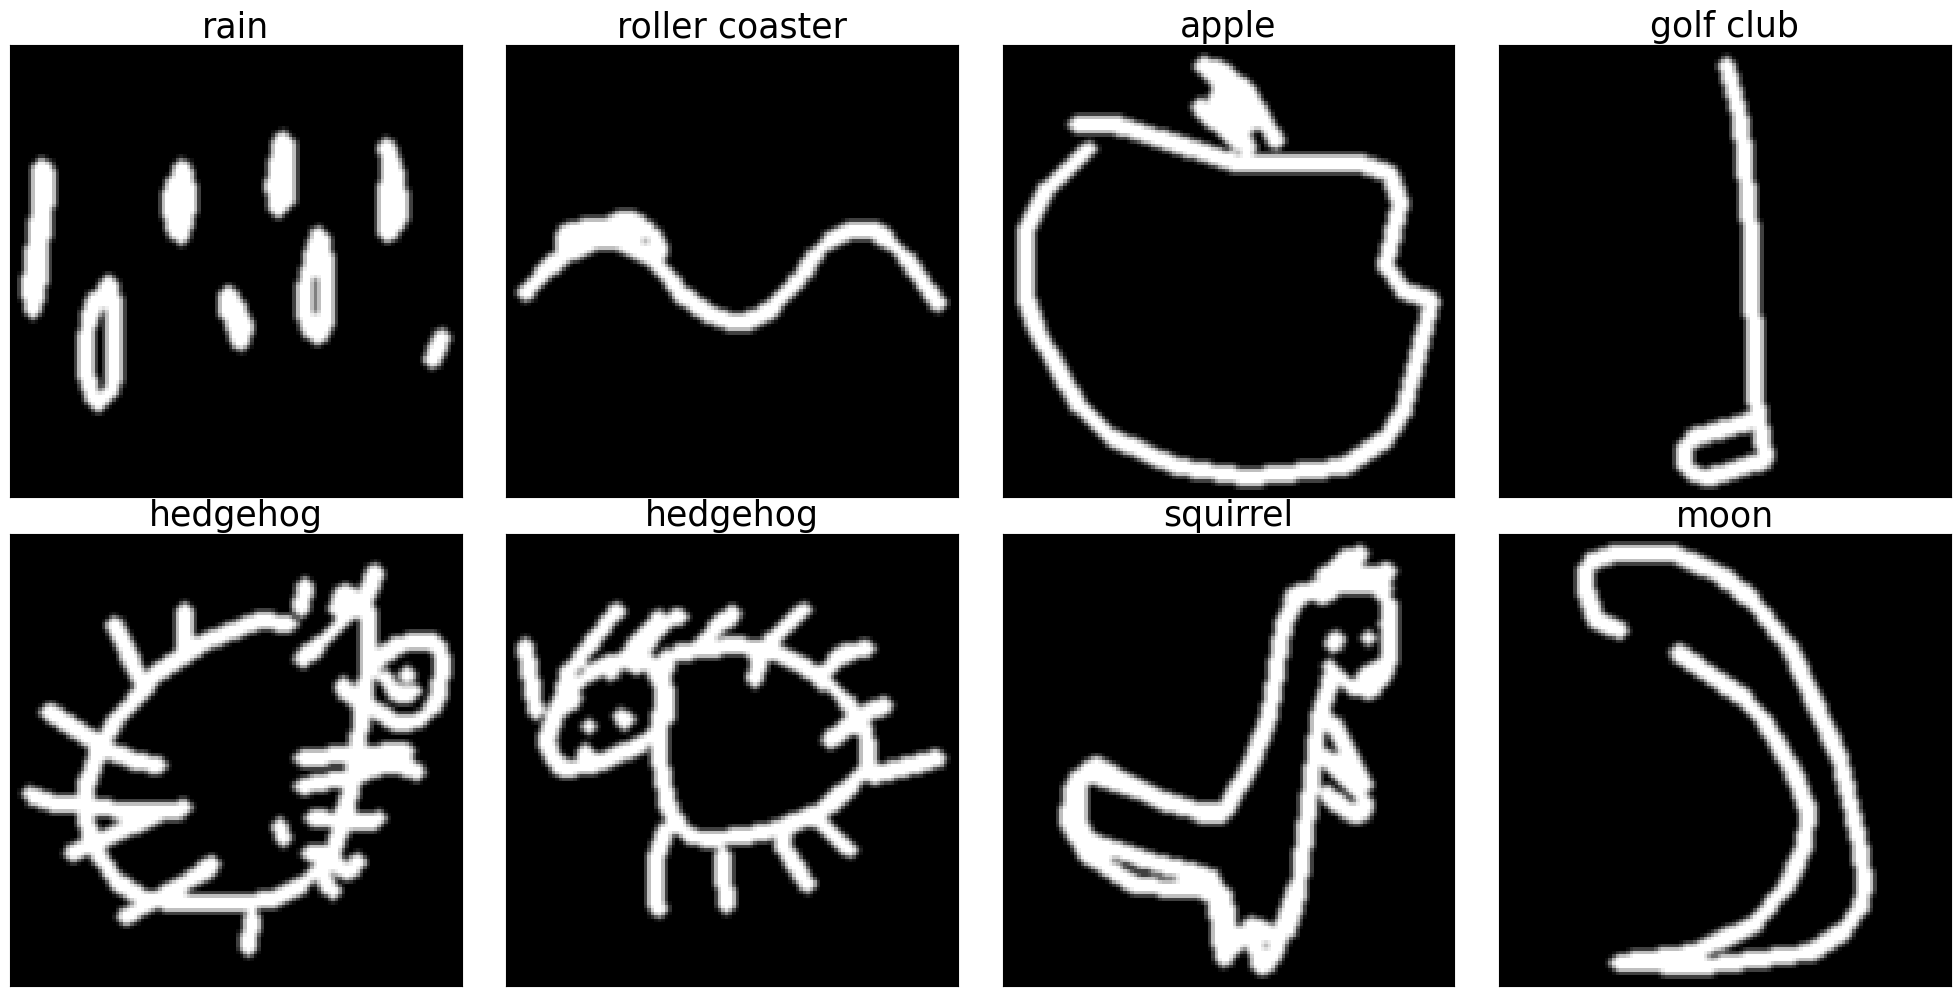

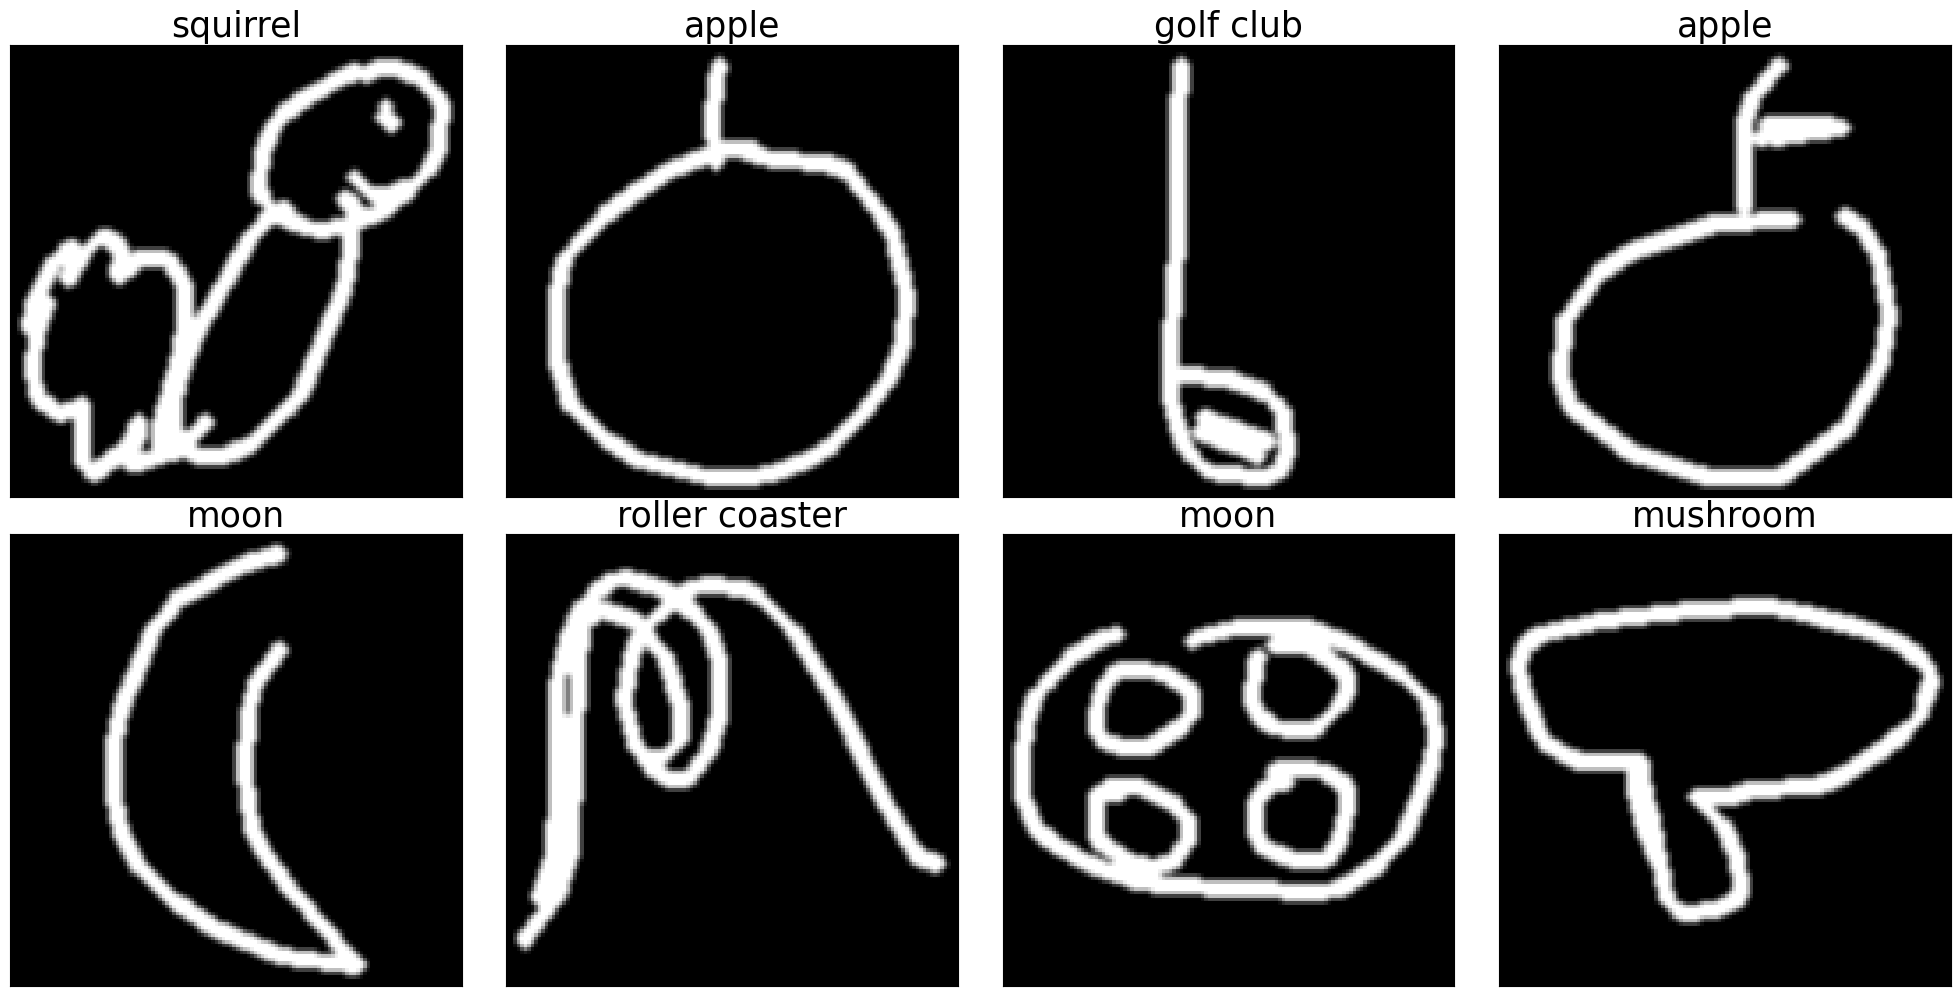

In [ ]:
Visualisation.plot_random_images(training_set, classes)

Visualisation.plot_random_images(training_set, classes)

## Autoencoder class

In [ ]:
from src.conv_autoencoder_embed import ConvAutoencoderEmbed
from src.conv_autoencoder import ConvAutoencoder
from src.conv_variational_autoencoder import ConvVariationalAutoencoder
from src.linear_autoencoder_embed import LinearAutoencoderEmbed
from src.linear_variational_autoencoder import LinearVariationalAutoencoder

## Try with simple model

In [ ]:
conv_architecture = [1, 4, 8, 16, 32, 64]
linear_architecture = [WIDTH * HEIGHT, WIDTH * HEIGHT * 3 // 4]
rl=0.7
kl=0.3

MODEL_INIT = None
architecture = None
if "conv" in MODEL or "convolutionnal" in MODEL:
    architecture = conv_architecture
    if "variational" in MODEL:
        MODEL_INIT = ConvVariationalAutoencoder
    elif "embed" in MODEL or "embedded" in MODEL or "embedding" in MODEL:
        MODEL_INIT = ConvAutoencoderEmbed
    else:
        MODEL_INIT = ConvAutoencoder
elif "linear" in MODEL:
    architecture = linear_architecture
    if "variational" in MODEL or "var" in MODEL:
        MODEL_INIT = LinearVariationalAutoencoder
    elif "embed" in MODEL or "embedded" in MODEL or "embedding" in MODEL:
        MODEL_INIT = LinearAutoencoderEmbed

print("Chosen model : ", MODEL_INIT)

if "variational" in MODEL:
    autoencoder_model = MODEL_INIT(architecture, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, rl=rl, kl=kl)
else:
    autoencoder_model = MODEL_INIT(architecture, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True)
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = autoencoder_model.vae_loss if "variational" in MODEL else nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

Chosen model :  <class 'src.linear_autoencoder_embed.LinearAutoencoderEmbed'>


In [ ]:
# Print architecture 
autoencoder_model.print_model()

nb_params = sum(p.numel() for p in autoencoder_model.parameters() if p.requires_grad)
print("Nb params", nb_params)

# Compression factor 
print(f'Compression factor: {(len(architecture)-2)*2}')

Sequential(
  (encoder_0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_0): ReLU()
  (encoder_max_pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_1): ReLU()
  (encoder_max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_1): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_relu_2): ReLU()
  (encoder_max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_dropout_2): Dropout(p=0.1, inplace=False)
  (en

In [ ]:
# Check if path exists for weight, else path not and will train

path = os.path.join(PytorchUtils.WEIGHTS_FOLDER, PytorchUtils.give_file_name(autoencoder_model, EPOCHS))

if not os.path.exists(path):
    path = None

autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, optimizer, criterion, EPOCHS, path=path)

loading weights from : weigths/ConvAutoencoderEmbed_50_epochs.pt
attempting to train 50 epochs but 50 epochs already done -> no training performed


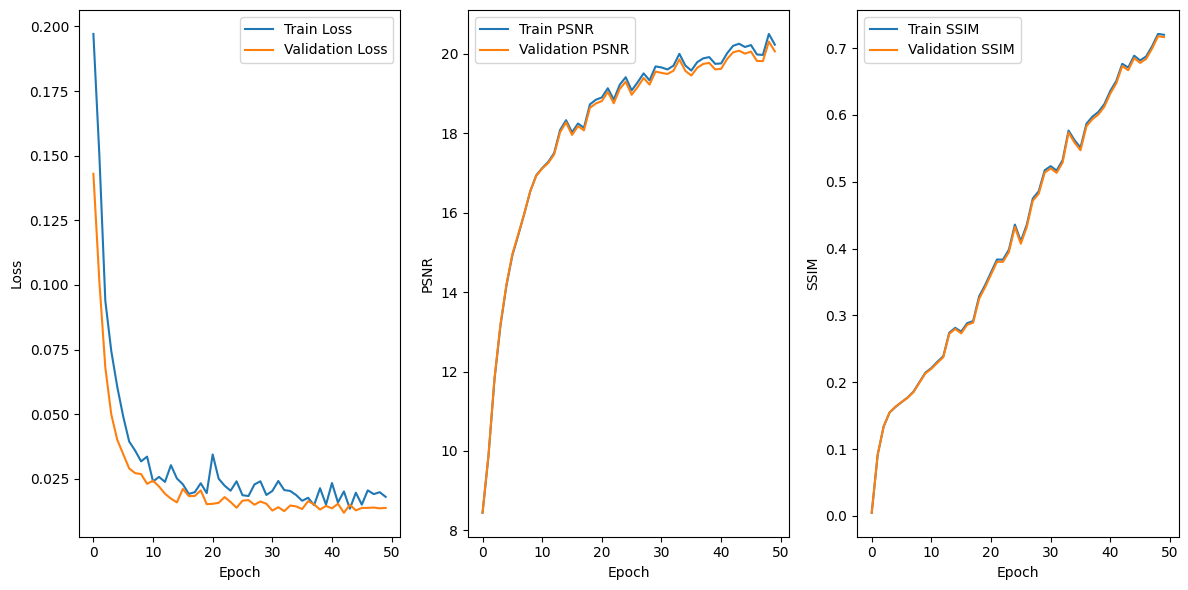

In [ ]:
autoencoder_model.plot_psnr_ssim()

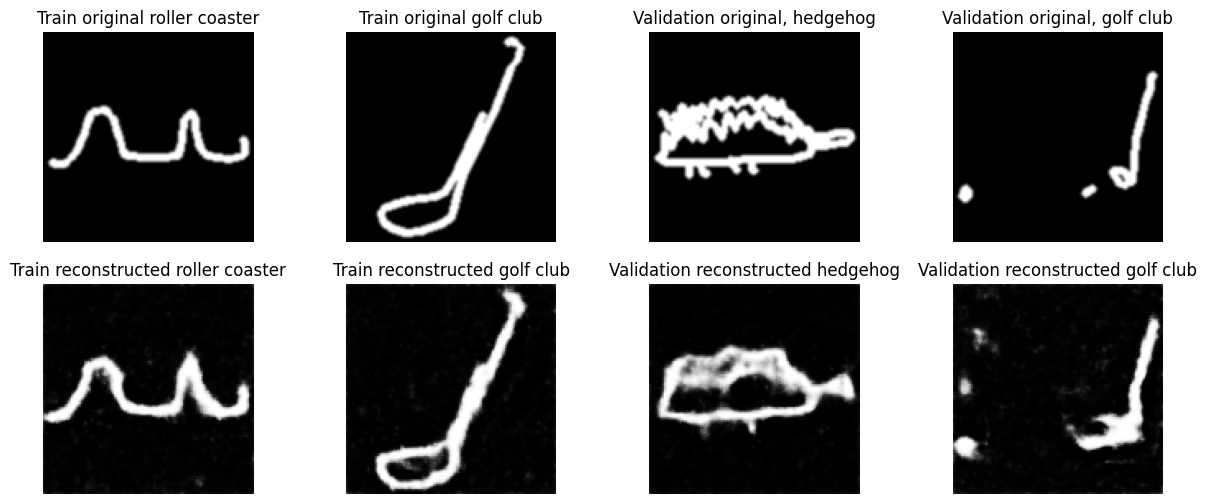

In [ ]:
autoencoder_model.show_images(training_set, validation_set)

In [ ]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [ ]:
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

Lowest PSNR index: 469|12.041417518963584, Lowest SSIM index: 388|0.43047072205850495


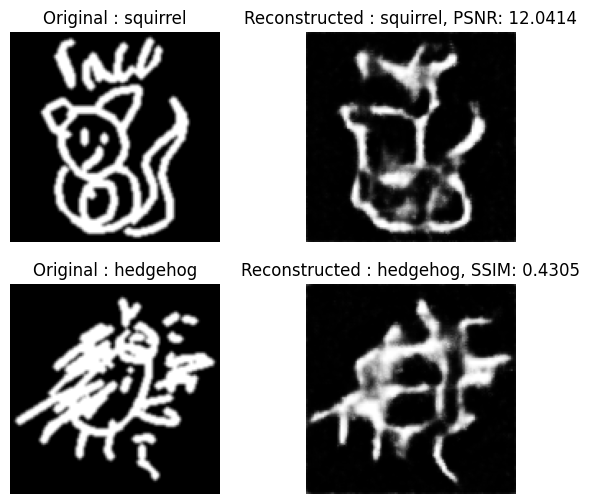

In [ ]:
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

# Show latent space